In [10]:
import psycopg2 as ps
import pandas as pd
import numpy as np

import requests
import json
import io

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.metrics import ndcg_score, accuracy_score
import random

import chgk_api as cha

# настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

In [11]:
# настройки

# количество вопросов "виртуальной перестрелки", кототорое планируем моделировать
test_distnce = 8

# процентили, на которые мы разделили выборрку турнира по стартовому рейтингу
first_percentile = 0.1
second_percentile = 0.5

# количество команд, которые участвуют в построении метрики
k_opt = 200

# тестовый турнир для проверки работы функций
# гостинный двор-2024, калуга
# tourn_id = 10707
# Островок Бесконечности: октябрь
tourn_id = 10396

In [12]:
def make_metrics(df, segment_col, target_col, pred_col, k=5, is_size=True, suffix='', param_value='', param_col='', tourn_id=0):
    """
    Функция для точности прогноза. 
    Сейчас это ndcg_score https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ndcg_score.html
    """
    work_df = df.copy()
    work_df.sort_values(by=[target_col, segment_col], ascending=[True, True])
    grouped = work_df.groupby(segment_col)
    ndcg_lst = []
    acc_lst = []

    for name, group in grouped:
        group = group.sort_values(by=target_col)
        y_true = np.array([group[target_col]])
        y_pred = np.array([group[pred_col]])
        
        ndcg = ndcg_score(y_true, y_pred, k=k)
        ndcg_lst.append({segment_col: name, 'ndcg': ndcg})

        # accuracy_score не работает с float, 
        # поэтому выводим дробную часть в виде числа
        # y_true = (y_true * 10).astype('int')
        # y_pred = (y_pred * 10).astype('int')
        # поэтому округляем вниз, делённое место считаем целевым
        y_true = np.floor(y_true).astype('int')
        y_pred = np.floor(y_pred).astype('int')

        acc = accuracy_score(y_true[0], y_pred[0])
        acc_lst.append({segment_col: name, 'accuracy': acc})

    metrics_df = work_df.groupby(segment_col).agg(
                                                    size = ('team_id', 'nunique'),
                                                    ).reset_index()
    ndcg_df = pd.DataFrame(ndcg_lst)
    acc_df = pd.DataFrame(acc_lst)

    metrics_df = metrics_df.merge(ndcg_df, 'left', on=segment_col)
    metrics_df = metrics_df.merge(acc_df, 'left', on=segment_col)

    if is_size == False:
        del metrics_df['size']
        metrics_df.columns = ['segment', 'ndcg'+suffix, 'accuracy'+suffix]
    else:
        metrics_df.columns = ['segment', 'size', 'ndcg'+suffix, 'accuracy'+suffix]
    
    metrics_df['tourn_id'] = tourn_id
    metrics_df[param_col] = param_value

    return metrics_df

def get_target(df):
    """
    Функция для расчёта целевой метрики
    Сейчас - это ранг суммы взятых с усреднением
    """
    totals_df = df.groupby(['tourn_id', 'team_id']).agg(
        target_question = ('qv_result', 'sum'),
    ).reset_index()
    totals_df['target'] = totals_df.groupby(['tourn_id'])['target_question'].rank(method='average', ascending=False)

    return totals_df

def get_current_taken_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по взятым".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num вопроса
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)
    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

def get_current_qv_rating_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по рейтингу взятых вопросов".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num по рейтингу взятых
    """
    # статистика по вопросам
    qv_stat_df = df.groupby(['tourn_id', 'question_num']).agg(
        taked = ('qv_result', 'sum'),
        total = ('qv_result', 'count'),
    ).reset_index()
    # рейтинг вопроса - количество команд, которые его не взяли
    qv_stat_df['qv_rating'] = qv_stat_df['total'] - qv_stat_df['taked']

    qv_df = df.merge(qv_stat_df, 'left', on=['tourn_id', 'question_num'])
    # вопросный рейтинг команды - суммарный рейтинг вопросов, которые она взяла  
    qv_df['rating'] = qv_df['qv_rating'] * qv_df['qv_result'] 

    gr_df = qv_df[qv_df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_rating = ('rating', 'sum'),
    ).reset_index()
    gr_df['rating_place'] = gr_df.groupby(['tourn_id'])['current_rating'].rank(method='average', ascending=False)

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])

    return gr_df

def get_data(tourn_id):
    """
    Функция для сборки датасета и проставлении необхоимых полей
    """
    # получаем данные по API
    tourn_df, question_df, players_df = cha.get_tourn_result(tourn_id)
    qv_stat = cha.tourn_stat(question_df)

    # назначаем командам сегмент по стартовой крутости
    tourn_df['segment'] =np.where(
        (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.1)), '1.top_10%',
        np.where(
                    (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.5)) &
                    (tourn_df['predictedPosition'] > tourn_df['predictedPosition'].quantile(.1)), '2.top_50%', '3.bottom_50%'
                )
                                )
    

    # собираем нужный датасет
    work_df = qv_stat.merge(tourn_df[['tourn_id', 'team_id', 'predictedPosition', 'position', 'segment']], 'left', on=['tourn_id', 'team_id'])
    work_df['qv_result'] = work_df['qv_result'].astype('int')

    work_df = work_df.sort_values(by=['tourn_id', 'predictedPosition', 'segment', 'team_id', 'question_num'])

    return tourn_df, question_df, players_df, work_df

In [20]:
# проверяем работу функций
# собранный датассет по одному турниру
tourn_df, question_df, players_df, work_df = get_data(tourn_id)
work_df.sample(3)

200


,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position,segment
2642,10396,56312,36,10,1,244.0,143.5,3.bottom_50%
985,10396,26706,36,4,1,154.0,159.0,3.bottom_50%
4553,10396,100252,36,17,1,238.0,100.0,3.bottom_50%


In [21]:
# прогноз по занятому месту к 12 вопросу по сегменту стартовой крутости
grtf = get_current_taken_forecast(work_df, 12, 'segment')
grtf.sample(3)

,tourn_id,team_id,segment,current_res,target_question,target,current_place
209,10396,92677,1.top_10%,10,31,13.5,20.5
187,10396,90990,3.bottom_50%,5,21,159.0,181.0
231,10396,95858,1.top_10%,10,32,7.5,20.5


In [22]:
# метрики точности прогноза по сегментам
make_metrics(
                grtf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                k=k_opt,
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,1.top_10%,28,0.963189,0.035714,10396,
1,2.top_50%,111,0.978646,0.000000,10396,
2,3.bottom_50%,139,0.986003,0.035971,10396,


In [23]:
# по всей выборке тоже можно сделать
make_metrics(
                grtf, 
                segment_col='tourn_id', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,10396,278,0.980585,0.021583,10396,


In [24]:
# прогноз по рейтингу взятых вопросов к 12 вопросу по сегменту стартовой крутости
gcqrf = get_current_qv_rating_forecast(work_df, 12, 'segment')
gcqrf.sample(3)

,tourn_id,team_id,segment,current_rating,rating_place,target_question,target
127,10396,79513,3.bottom_50%,281,246.0,21,159.0
41,10396,42558,2.top_50%,1015,53.5,23,129.5
168,10396,89218,3.bottom_50%,422,205.5,18,212.5


In [25]:
# метрики точности прогноза по сегментам
make_metrics(
                gcqrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='rating_place', 
                is_size=True, 
                suffix='_qv_rating_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_qv_rating_forecast,accuracy_qv_rating_forecast,tourn_id,
0,1.top_10%,28,0.919986,0.071429,10396,
1,2.top_50%,111,0.887277,0.000000,10396,
2,3.bottom_50%,139,0.952107,0.014388,10396,


In [26]:
# прогноз по стартовому рейтингу
trdf = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,28,0.471697,0.107143,10396,
1,2.top_50%,111,0.768037,0.009009,10396,
2,3.bottom_50%,139,0.966223,0.007194,10396,


In [27]:
# прогноз по случайной тасовке команд
places = list(range(1, len(trdf)+1))
random.shuffle(places)
trdf['random'] = places
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,28,0.553897,0.0,10396,
1,2.top_50%,111,0.307693,0.0,10396,
2,3.bottom_50%,139,0.508001,0.0,10396,


In [28]:
# а теперь проход по всем вопроса турнира
num_of_questions = work_df['numqv'].values[0]
num_of_teams = work_df['team_id'].nunique()

questions = pd.DataFrame(range(1, num_of_questions+1), columns=['question_num'])
questions['tourn_id'] = tourn_id

# прогноз по стартовому рейтингу
teams_smpl = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
start_df_forec = make_metrics(
                teams_smpl, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                k=k_opt,
                suffix='_start_rating_forecast', 
                tourn_id=tourn_id)

res_df = questions.merge(start_df_forec, 'left', on='tourn_id')

# прогноз по случайной тасовке команд
places= list(range(1, len(teams_smpl)+1))
random.shuffle(places)
teams_smpl['random'] = places
# shuffle_forecast = make_metrics(teams_smpl, 'segment', 'position', 'random')
shuffle_forecast = make_metrics(
                teams_smpl, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=False, 
                k=k_opt,
                suffix='_shuffle_forecast', 
                tourn_id=tourn_id)


res_df = res_df.merge(shuffle_forecast, 'left', on=['segment'], suffixes=('', '_random'))

qv_forecast_metric_df = pd.DataFrame()
rating_forecast_metric_df = pd.DataFrame()
for i in range(1, num_of_questions+1):
    qv_forecast_df = get_current_taken_forecast(work_df, i, 'segment')
    rating_forecast_df = get_current_qv_rating_forecast(work_df, i, 'segment')

    qv_forecast_metric_df_b = make_metrics(
                    qv_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='current_place', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_current_place_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)
#     rating_forecast_metric_df_b = make_metrics(rating_forecast_df, 'segment', 'target', 'rating_place')
    rating_forecast_metric_df_b = make_metrics(
                    rating_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='rating_place', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_qv_rating_place_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)

    qv_forecast_metric_df = pd.concat([qv_forecast_metric_df, qv_forecast_metric_df_b])
    rating_forecast_metric_df = pd.concat([rating_forecast_metric_df, rating_forecast_metric_df_b])

res_df = res_df.merge(qv_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
res_df = res_df.merge(rating_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])

In [29]:
len(res_df)

108

In [30]:
res_df.sample(3)

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast
25,9,10396,2.top_50%,111,0.924062,0.009009,,0.818781,0.018018,10396,,0.958633,0.027027,0.952737,0.018018
41,14,10396,3.bottom_50%,139,0.981152,0.007194,,0.925815,0.000000,10396,,0.989289,0.000000,0.988198,0.028777
79,27,10396,2.top_50%,111,0.924062,0.009009,,0.818781,0.018018,10396,,0.992699,0.000000,0.987954,0.027027


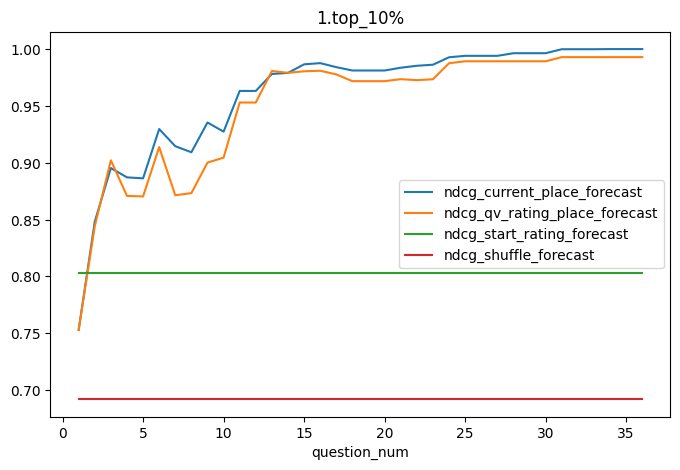

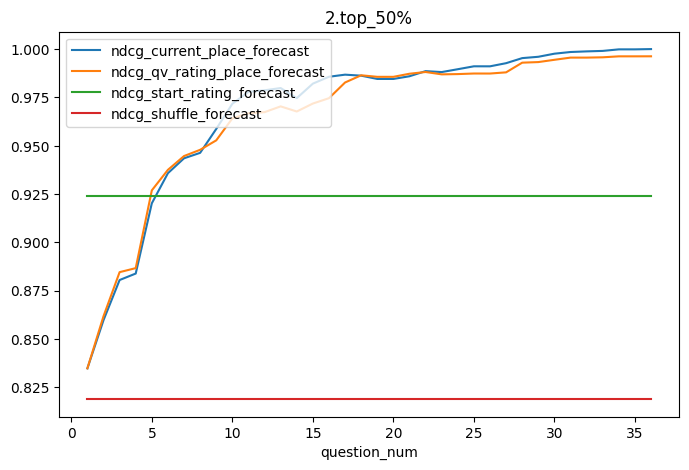

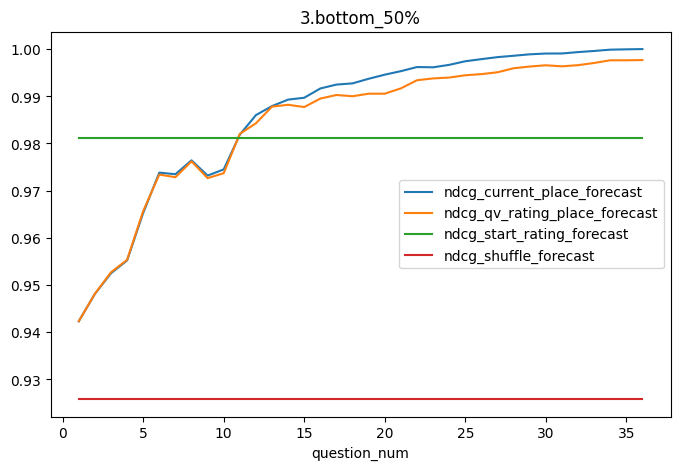

In [31]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', 
                                                                    ]].plot(title=segment)

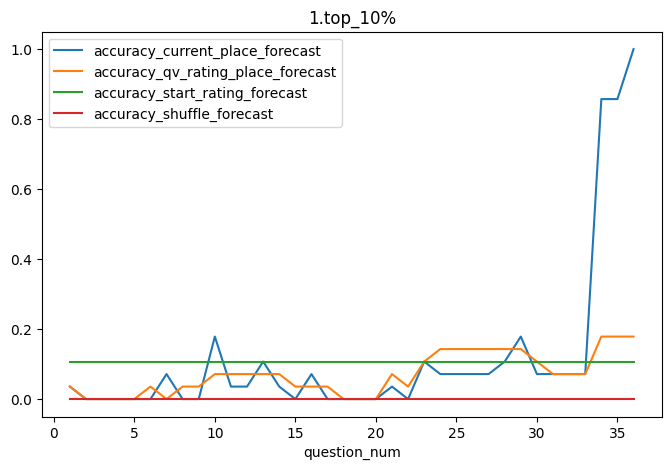

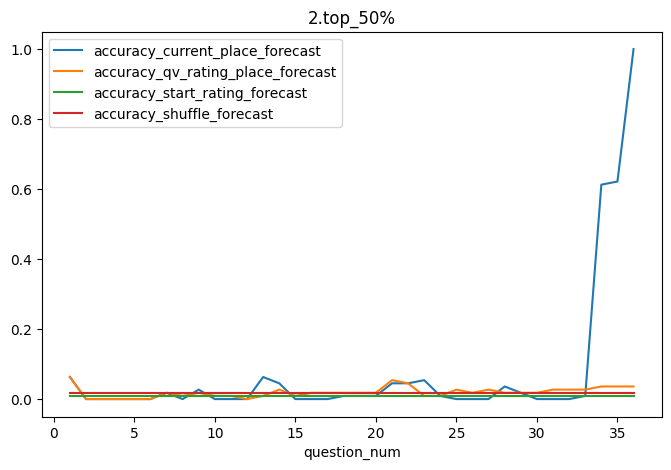

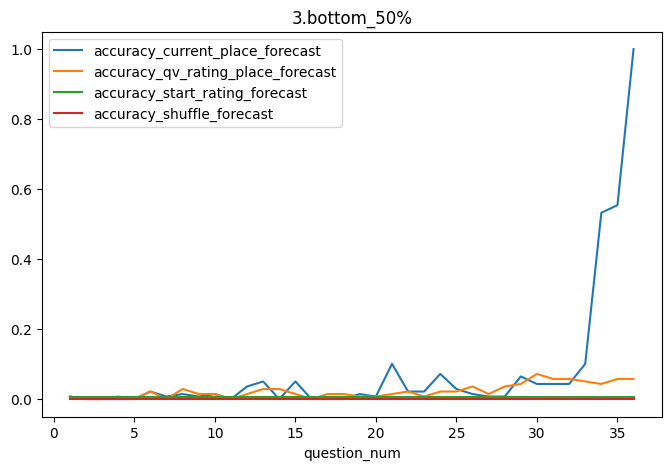

In [32]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'accuracy_current_place_forecast', 
                                                                    'accuracy_qv_rating_place_forecast',
                                                                    'accuracy_start_rating_forecast', 
                                                                    'accuracy_shuffle_forecast', 
                                                                    ]].plot(title=segment)

In [34]:
# в качестве прогноза берём ситуацию перед начало "виртуальной перестрелки"
res_df[res_df['question_num'] == num_of_questions - test_distnce].set_index('segment')[[                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', ]].T

segment,1.top_10%,2.top_50%,3.bottom_50%
ndcg_current_place_forecast,0.996372,0.995321,0.998585
ndcg_qv_rating_place_forecast,0.989280,0.992967,0.995932
ndcg_start_rating_forecast,0.803411,0.924062,0.981152
ndcg_shuffle_forecast,0.692172,0.818781,0.925815


In [ ]:
# question_df, players_df, work_df

In [37]:
tourn_df[0:3]

,tourn_id,team_id,team_name,position,result,is_sinh,venue,is_rating,rg,d,predictedPosition,segment
0,10396,53714,Постмодернистское название,1.5,34,1,ИгрыРазума,True,11701,85,4.0,1.top_10%
1,10396,57024,Вжух,1.5,34,1,ИгрыРазума,True,13006,29,1.0,1.top_10%
2,10396,67543,Холодно и мокро,3.5,33,1,ИгрыРазума,True,12064,27,3.0,1.top_10%


In [5]:
tt = cha.get_tourn_list('2024-12-06', '2024-12-09', 1)

200


In [6]:
tt[0:40]

,tourn_id,tourn_name,type,season,difficulty_forecast,is_rating,questionQty
0,10876,Чемпионат Перми и Пермского края,Обычный,59,4.0,True,"{'1': 12, '2': 12, '3': 12, '4': 12}"
1,11304,Беловежская зима - 2024,Обычный,59,5.5,True,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}"
2,11594,Кубок МИФИ 2024 2,Обычный,59,4.5,False,"{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12, '6': 12, '7': 12}"
3,11618,Зимний турнир,Обычный,59,0.0,False,"{'1': 12, '2': 12, '3': 12, '4': 12}"


In [7]:
jdt = tt['questionQty'].values[1]

In [13]:
tourn_df, question_df, players_df, work_df = get_data(11304)

200


In [14]:
jdt

{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}

In [15]:
def get_tours_distr(json_data):
    size = len(json_data)
    qv_lst = []
    tour_lst = []
    max_qv = 0
    for t in range(1, size+1):
        rr = range(max_qv+1, max_qv+json_data[str(t)]+1)
        max_qv = rr[-1]
        for q in rr:
            qv_lst.append(q)
            tour_lst.append(t)
    
    df = pd.DataFrame(qv_lst, columns=['question_num'])
    df['tour_id'] = tour_lst
    return df

In [17]:
tours_distr = get_tours_distr(jdt)

In [20]:
work_df.sample(3)

,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position,segment,tour_id
2427,11304,5209,90,88,0,27,25.0,3.bottom_50%,6
2733,11304,7015,90,34,0,31,27.0,3.bottom_50%,3
2257,11304,96534,90,8,1,26,30.0,3.bottom_50%,1


In [19]:
work_df = work_df.merge(tours_distr, 'left', on='question_num')

In [23]:
def get_tours_res_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза 
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', 'tour_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)
    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id', 'tour_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

In [25]:
tts = get_tours_res_forecast(work_df, 45, 'segment')
tts[tts['team_id'] == 55336]

,tourn_id,team_id,tour_id,segment,current_res,target_question,target,current_place
38,11304,55336,3,2.top_50%,12,64,3.0,3.0
36,11304,55336,1,2.top_50%,12,64,3.0,3.5
37,11304,55336,2,2.top_50%,10,64,3.0,8.0
